### Enable autoreload

In [13]:
# Sørger for at alle importerede python filer geninlæses ved import statements
# Nødvedigt, hvis ændinger skal tage effekt uden at genstarte Python Kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Indlæs nødvendige libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import mymlr as mlr
np.set_printoptions(precision=4, suppress=False, floatmode='maxprec_equal', formatter={'float_kind': '{:g}'.format})

### Histogram til at visualisere fordelinger

In [15]:
def histogram(stat, truestat=None, title='Histogram', xlim=None, bins=50, normdensity=True):
    plt.rcParams.update({'font.size': 16})
    if truestat is None:
        truestat = stat.mean()
    fig, ax = plt.subplots(1, len(stat.columns), figsize=(15, 4))
    for i, lbl in enumerate(stat.columns):
        mcsd = stat[lbl].std();
        ax[i].hist(stat[lbl], bins=bins, density=True, alpha=0.7)
        ax[i].axvline(x=truestat[i], color='red', linestyle='--')
        if normdensity:
            x = np.linspace(truestat[i]-4*mcsd, truestat[i]+4*mcsd, 100)
            y = norm.pdf(x, loc=truestat[i], scale=mcsd)
            ax[i].plot(x, y, color='black')
        ax[i].set_title(lbl)
        if xlim is not None:
            ax[i].set_xlim(xlim)
        else:
            ax[i].set_xlim(truestat[i]-4*mcsd, truestat[i]+4*mcsd)

    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

### Monte Carlo Simulator

In [16]:
def monte_carlo(simulator, S=1000):
    # Loop over repetitions
    for s in range(S):
        # Simulate data
        data = simulator()        

        # Estimate model
        res = mlr.ols(data[['const', 'x1', 'x2']], data['y'])

        # Store results
        if s==0:
            beta_hat = pd.DataFrame(index=range(S), columns=res['lbl_X'])
            se = pd.DataFrame(index=range(S), columns=res['lbl_X'])

        beta_hat.loc[s]= res['beta_hat'].T[0]
        se.loc[s]= res['standard_errors'].T[0]

    return beta_hat, se

def summary_table(b,se, beta0): 
    sumtab = {'Parameter': b.columns,'True Value': beta0, 'Mean Estimate': b.mean(),
        'MC Standard Deviation': b.std(),'Average SE': se.mean()}
    display(pd.DataFrame(sumtab))

#  Målefejl og Stikprøve udvælgelse

### Econometrics A (ØkA)

Bertel Schjerning

Department of Economics, University of Copenhagen


# Part 1: Målefejl i den forklarende variabel

### Introduktion af målefejl i $x_2$

$$
y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i}^* + u_i, \quad u_i \sim \mathcal{N}(0, \sigma_u^2)
$$
$$
x_{1i} \sim \mathcal{N}(\mu_{x_1}, \sigma_{x_1}^2)
$$
$$
x_{2i}^* \sim \mathcal{N}(\mu_{x_2}, \sigma_{x_2}^2)
$$
$$
x_{2i} = x_{2i}^* + e_i, \quad e_i \sim \mathcal{N}(\mu_e, \sigma_e^2)
$$

- $y_i$: afhængig variabel
- $x_{1i}$: trukket fra en normalfordeling med middelværdi $\mu_{x_1}$ og varians $\sigma_{x_1}^2$
- $x_{2i}^*$: sand værdi af $x_{2i}$, også normalfordelt med middelværdi $\mu_{x_2}$ og varians $\sigma_{x_2}^2$
- $x_{2i}$: indeholder målefejl $e_i$
- $e_i$: målefejl, trukket fra en normalfordeling med middelværdi $\mu_e$ og varians $\sigma_e^2$
- $u_i$: fejlled i regressionen

In [17]:
def simulate(n=100, beta=[0, 1, 2], mu_x=[0,0], sigma_x=[1,1], mu_e=0, sigma_e=1, sigma_u=1):

    gen_u = lambda mu, sigma, size: np.random.standard_t(3, size)*sigma + mu

    const = np.ones(n)
    u = np.random.normal(0, sigma_u, size=n) # Error term
    e = np.random.normal(mu_e, sigma_e, size=n) # Measurement term
    x1 = np.random.normal(mu_x[0], sigma_x[0], size=n) # 
    x2_star = np.random.normal(mu_x[1], sigma_x[1], size=n) # True value
    x2 = x2_star + e
    y = beta[0] + beta[1] * x1 + beta[2] * x2_star + u
    
    return pd.DataFrame({'y': y,'const': const,'x1': x1,'x2': x2, 'u': u, 'e': e})

# Experimenter/Spørgsmål

- Hvad sker der med OLS-estimaterne, når der **ingen målefejl** er (σₑ = 0)?  
- Hvad sker der, når vi **introducerer klassisk målefejl** (σₑ > 0)?  
- Hvordan påvirker størrelsen af σₑ **størrelsen af bias**?  
- Hvordan påvirker stikprøvestørrelsen n estimaterne?  
- Er OLS stadig konsistent, når vi har målefejl?  
- Hvordan ser vi brud på MLR.4 i data (korrelation mellem x og fejlleddet)?  
- Hvad sker der med **konfidensintervallerne** – dækker de sande parametre?  

### Simuler data og lav beskrivende statistik
Er MLR.1-MLR.4 opfyldt

In [18]:
df = simulate(n=1000000, beta=[0, 1, 2], sigma_e=1)
print(f'Beskrivende statistik:'); display(df.describe().round(3))
print(f'Correlations matrix:'); display(df.corr().round(3))

Beskrivende statistik:


,y,const,x1,x2,u,e
count,1000000.000,1000000.0,1000000.000,1000000.000,1000000.000,1000000.000
mean,0.003,1.0,0.000,0.002,0.000,0.000
std,2.448,0.0,1.000,1.414,0.999,1.001
min,-10.983,1.0,-4.847,-6.791,-5.141,-5.003
25%,-1.645,1.0,-0.673,-0.953,-0.674,-0.675
50%,0.005,1.0,0.001,0.003,0.001,0.000
75%,1.652,1.0,0.675,0.955,0.673,0.675
max,11.789,1.0,4.488,6.485,5.120,4.742


Correlations matrix:


,y,const,x1,x2,u,e
y,1.000,NaN,0.408,0.577,0.407,-0.001
const,NaN,NaN,NaN,NaN,NaN,NaN
x1,0.408,NaN,1.000,-0.001,-0.001,-0.000
x2,0.577,NaN,-0.001,1.000,-0.001,0.707
u,0.407,NaN,-0.001,-0.001,1.000,-0.001
e,-0.001,NaN,-0.000,0.707,-0.001,1.000


### Simuler data og estimer model med OLS
- Er $\mathbf{\hat{\beta}}$ konsistent for $\beta$
- Hvad sker der når n er stor? Er $p\lim \mathbf{\hat{\beta}}=\mathbf{\beta}$ 
- Hvad sker der når $\sigma_{e}=0$ (eller meget lille)

### Asymptotisk bias på $\hat{\beta_2}$
plim $\hat{\beta_2}$ =$\beta_2 \frac{\sigma_{x_2^*}^2}{\sigma_e^2 + \sigma_{x_2^*}^2}$

In [19]:
sigma_e=1; 
beta0=[0,1,-2]; sigma_x0=[1,1,1]
plim_b2hat=beta0[2]*(sigma_x0[2]**2)/(sigma_e**2 + sigma_x0[2]**2)
print(f'true (beta0[2])={beta0[2]}')
print(f'plim_b2hat={plim_b2hat}')
print(f'Asymptotisk bias={plim_b2hat-beta0[2]}')

simulator1 = lambda: simulate(n=1000, beta=beta0, sigma_x=sigma_x0, sigma_e=sigma_e)
b, se = monte_carlo(simulator1, S=1000)
summary_table(b,se, beta0)

true (beta0[2])=-2
plim_b2hat=-1.0
Asymptotisk bias=1.0


,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
const,const,0,0.000387,0.054657,0.054788
x1,x1,1,0.999848,0.05464,0.054786
x2,x2,-2,-1.000674,0.03867,0.038776


### Fordeling af OLS estimatoren

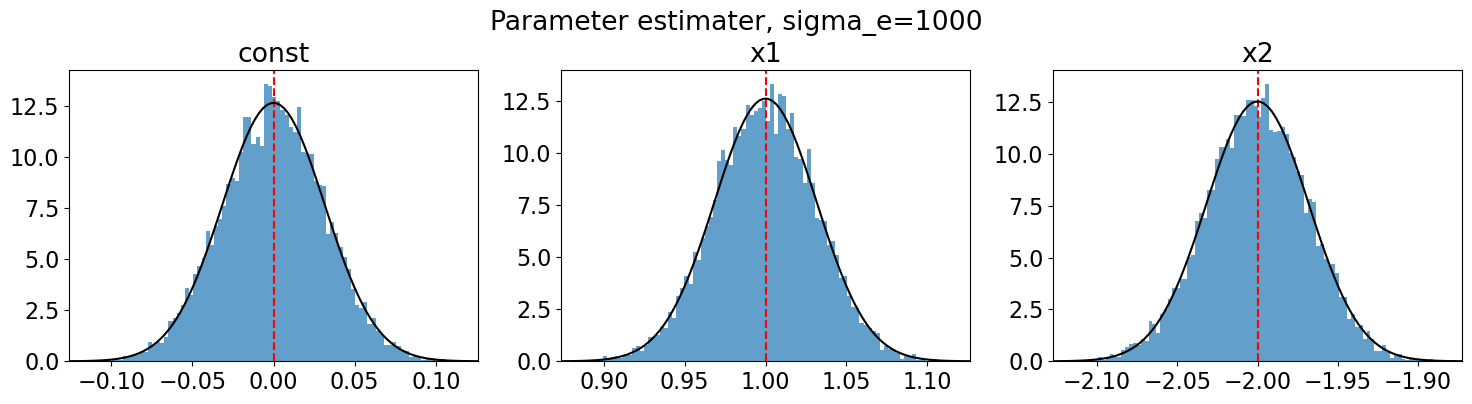

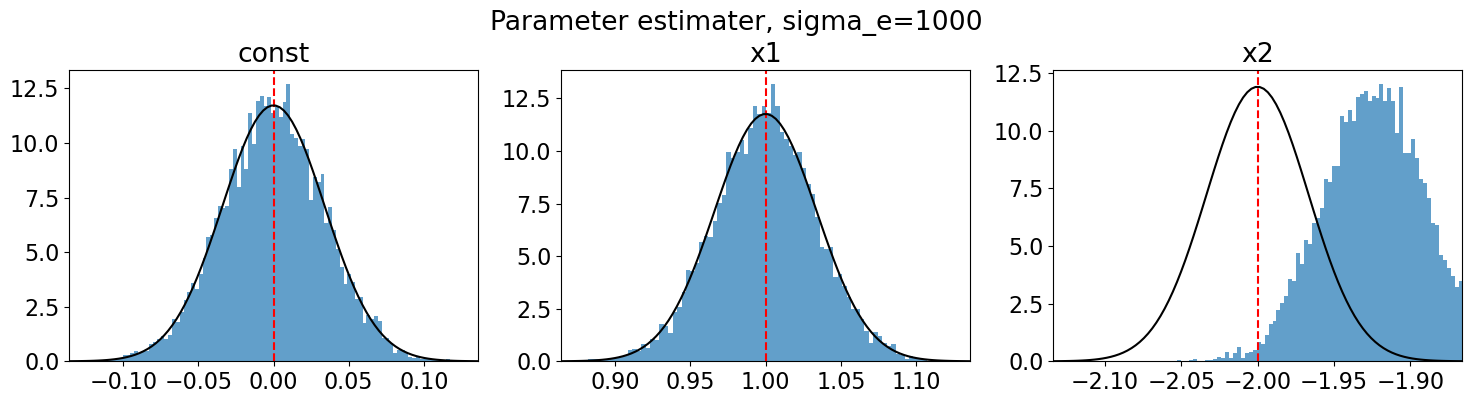

In [20]:
beta0=[0,1,-2]; n=1000; 
sigma_e=0; b, se = monte_carlo(lambda: simulate(n, beta=beta0, sigma_e=sigma_e), S=10000)
histogram(stat=b, truestat=beta0, bins=100, title=f'Parameter estimater, sigma_e={n}');
sigma_e=0.2; b, se = monte_carlo(lambda: simulate(n, beta=beta0, sigma_e=sigma_e), S=10000)
histogram(stat=b, truestat=beta0, bins=100, title=f'Parameter estimater, sigma_e={n}');


# Konklusioner

- Uden målefejl (σₑ = 0): OLS er unbiased og konsistent.  
- Med klassisk målefejl: β₂ bliver **dæmpet mod nul** (attenuation bias).  
- Bias vokser, når σₑ stiger – følger reliabilitetsforholdet:  
  Var(x*) / [Var(x*) + Var(e)].  
- Større stikprøve n reducerer usikkerhed, men ikke bias → OLS er **inkonsistent**.  
- MLR.4 brydes: x₂ korrelerer med den sande fejlled → kilde til bias.  
- Konfidensintervaller ser “fine” ud, men dækker systematisk forkert værdi.  
- Take-away: Målefejl i forklarende variable er alvorlig – giver systematisk bias, som ikke kan fixes med større n eller robuste SE.  

# Part 2: Stikprøve udvælgelse

### Simulering af stikprøveudvælgelse

Den strukturelle ligning er:

$$ 
y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + u_i \quad u_i \sim \mathcal{N}(0, \sigma_u^2) 
$$

Selektionsligningen er:

$$ 
s^*_i = \delta_0 + \delta_1 x_{1i} + \delta_2 x_{2i} + v_i \quad v_i = e_i + \rho_{vu} u_i 
$$

Hvor $ s_i = 1 $ hvis $ s^*_i > 0 $, og ellers $ s_i = 0 $ (kun stikprøver med $ s_i = 1 $ udvælges).

#### Genereringsprocessen:
- $x_1, x_2$: Normalfordelte forklarende variable
- $ u_i \sim \mathcal{N}(0, \sigma_u^2) $: Fejlled i den strukturelle ligning
- $ e_i \sim \mathcal{N}(0, \sigma_e^2) $: Uafhængig del af fejlled i selektionsligningen
- $ v_i = e_i + \rho_{vu} u_i $: Fejlled i selektionsligningen korreleret med fejlleddet i den strukturelle ligning

## Simulering af selektionsmodel

In [22]:
def simulate(n=100, beta=[0, 1, 2], delta=[0, 0, 0], mu_x=[0,0], sigma_x=[1,1], sigma_u=1, sigma_e=1, rho_vu=0):
    const = np.ones(n)
    u = np.random.normal(0, sigma_u, size=n)  # Fejlled i strukturel ligning
    e = np.random.normal(0, sigma_e, size=n)  # Uafhængigt fejlled i selektionsligning
    v = e + rho_vu * u  # Fejlled i selektionsligning
    x1 = np.random.normal(mu_x[0], sigma_x[0], size=n)  # Forklarende variabel 1
    x2 = np.random.normal(mu_x[1], sigma_x[1], size=n)  # Forklarende variabel 2
    y = beta[0] + beta[1] * x1 + beta[2] * x2 + u  # Strukturel ligning (output)
    
    # Selektionsmodel
    s_star = delta[0] + delta[1] * x1 + delta[2] * x2 + v  # Selektionsligning
    s = (s_star > 0).astype(int)  # Udvælg stikprøver, hvor s_star > 0

    # Dataframes for udvalgte og fulde sample
    df = pd.DataFrame({'y': y, 'const': const, 'x1': x1, 'x2': x2, 'u': u, 'e': e, 's': s})
    df_selected = df[df["s"] > 0]  # Udvalgt sample

    return df_selected, df

## Sammenligning af fuld og selekteret stikprøve

### Er er selektion korrelerete med fejlled og de forklarende variable, og er det et problem? 
- **Tilfældig udvælgelse** ($\delta = 0$, $\sigma_e \neq 0$, $\rho_{vu} = 0$)
- **Udvælgelse baseret på forklarende variable** ($\delta \neq 0$)
- **Udvælgelse baseret på variable, vi ikke kontrollerer for som er korreleret med u** ($\rho_{vu} \neq 0$, $v$ korreleret med $u$):


In [23]:
df_selected, df_all = simulate(n=10000, delta=[0, 0, 0], beta=[0, 1, 2], sigma_e=1, rho_vu=0)
for df in [df_all, df_selected]:
    print(f'Beskrivende statistik:'); display(df.describe().round(3))
    print(f'Correlations matrix:'); display(df.corr().round(3))


Beskrivende statistik:


,y,const,x1,x2,u,e,s
count,10000.000,10000.0,10000.000,10000.000,10000.000,10000.000,10000.000
mean,-0.030,1.0,-0.010,-0.007,-0.007,-0.004,0.501
std,2.448,0.0,1.007,1.000,1.003,0.992,0.500
min,-10.154,1.0,-3.438,-3.693,-3.671,-4.007,0.000
25%,-1.674,1.0,-0.692,-0.676,-0.686,-0.657,0.000
50%,-0.035,1.0,-0.007,-0.005,-0.010,0.003,1.000
75%,1.620,1.0,0.671,0.647,0.655,0.674,1.000
max,10.179,1.0,3.763,3.712,3.665,3.614,1.000


Correlations matrix:


,y,const,x1,x2,u,e,s
y,1.000,NaN,0.403,0.817,0.407,-0.017,-0.014
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x1,0.403,NaN,1.000,-0.003,-0.014,-0.018,-0.010
x2,0.817,NaN,-0.003,1.000,0.004,-0.001,-0.002
u,0.407,NaN,-0.014,0.004,1.000,-0.021,-0.019
e,-0.017,NaN,-0.018,-0.001,-0.021,1.000,0.796
s,-0.014,NaN,-0.010,-0.002,-0.019,0.796,1.000


Beskrivende statistik:


,y,const,x1,x2,u,e,s
count,5013.000,5013.0,5013.000,5013.000,5013.000,5013.000,5013.0
mean,-0.065,1.0,-0.020,-0.009,-0.026,0.784,1.0
std,2.430,0.0,1.007,0.984,1.003,0.590,0.0
min,-8.361,1.0,-3.438,-3.607,-3.320,0.000,1.0
25%,-1.691,1.0,-0.692,-0.669,-0.708,0.316,1.0
50%,-0.112,1.0,-0.014,-0.010,-0.037,0.672,1.0
75%,1.580,1.0,0.664,0.642,0.644,1.123,1.0
max,8.839,1.0,3.627,3.546,3.665,3.614,1.0


Correlations matrix:


,y,const,x1,x2,u,e,s
y,1.000,NaN,0.413,0.814,0.412,0.008,NaN
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x1,0.413,NaN,1.000,0.005,-0.012,-0.006,NaN
x2,0.814,NaN,0.005,1.000,0.005,0.007,NaN
u,0.412,NaN,-0.012,0.005,1.000,0.013,NaN
e,0.008,NaN,-0.006,0.007,0.013,1.000,NaN
s,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Stikprøveudvælgelse og bias

Hvornår forventer vi stikprøveudvælgelsesbias, når vi estimerer modellen

$$
y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + u_i
$$

på den udvalgte stikprøve (dvs. $s_i = 1$)?

Modellens ligninger

$$ 
y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + u_i \quad u_i \sim \mathcal{N}(0, \sigma_u^2) \\
s^*_i = \delta_0 + \delta_1 x_{1i} + \delta_2 x_{2i} + v_i \quad v_i = e_i + \rho_{vu} u_i \\
s_i = 1(s^*_i>0)
$$
### Hvornår får vi bias pga stikprøveudvælgelse?
- **Tilfældig udvælgelse** ($\delta = 0$, $\sigma_e \neq 0$, $\rho_{vu} = 0$)
- **Udvælgelse baseret på forklarende variable** ($\delta \neq 0$)
- **Udvælgelse baseret på variable, vi ikke kontrollerer for som er korreleret med u** ($\rho_{vu} \neq 0$, $v$ korreleret med $u$):


## Monte Carlo

In [29]:
def simulator1(): 
    df_selected, df_all = simulate(n=10000, delta=[0, 1, 0], beta=[0, 1, -2], sigma_e=1, rho_vu=1)
    return df_selected
b, se = monte_carlo(simulator1, S=1000)
summary_table(b,se, beta0)

,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
const,const,0,0.584552,0.013074,0.013628
x1,x1,1,0.730626,0.013522,0.013628
x2,x2,-2,-2.000398,0.011566,0.012098


### Hvornår får vi bias pga stikprøveudvælgelse?

Stikprøveudvælgelsesbias opstår, når $E(u|x, s = 1) \neq 0$. 

#### Lad os se på de forskellige scenarier:

- **Tilfældig udvælgelse** ($\delta = 0$, $\sigma_e \neq 0$, $\rho_{vu} = 0$):
  - Ingen bias, da $E(u|x, s = 1) = E(u|x) = 0$. Udvælgelsen er tilfældig og ikke korreleret med fejlleddet $u$. Estimaterne er middelrette.

- **Udvælgelse baseret på forklarende variable** ($\delta \neq 0$):
  - Ingen bias, fordi udvælgelsen kun afhænger af observerbare forklarende variable ($x_1$, $x_2$), som vi kontrollerer for i modellen. Da $E(u|x, s = 1) = 0$, er estimaterne middelrette.

- **Udvælgelse baseret på uobserverede variable korreleret med $u$** ($\rho_{vu} \neq 0$):
  - Bias opstår, fordi udvælgelsen er afhængig af uobserverede variable, der er korreleret med $u$. Dette fører til, at $E(u|x, s = 1) \neq 0$, hvilket introducerer stikprøveudvælgelsesbias i estimaterne af $\beta_0$, $\beta_1$ og $\beta_2$.

